# Overview of Content:

### mlo_07_filtered_correlations_fft

__Sections__:
- Main Module Import Section and Notebook Settings
- Initialize Custom Functions
- Read Notebook Variables
- Merge Filtered Time Series (Mauna Loa and ONI)
- Filtered Time Domain Signals: Mauna Loa- and ONI-Data
- Filtered Auto-Correlations
- Auto-Correlation - Mauna Loa and ONI
- Filtered Cross-Correlation: ONI x Mauna Loa
- FFT Calculations with Filtered Data
- Comparing Window Functions on Filtered Mauna Loa Data

__Save Dataframes as Notebook Variables and as Text Files__:
- Merge Filtered Time Series (Mauna Loa and ONI):
    - full_a_filtered
    - cut_a_filtered
- FFT Calculations with Filtered Data:
    - fft_filtered_mmlo
    - fft_filtered_mmlo_cut_a
    - fft_filtered_oeni
    - fft_filtered_oeni_cut_a

    
__Plot and Save Figures__:
- Filtered Time Domain Signals: Mauna Loa- and ONI-Data:
    - filtered_mmlo_oeni.pdf
- Filtered Auto-Correlations:
    - autocorr_mmlo_filtered.pdf
    - autocorr_oeni_filtered.pdf
- Auto-Correlation - Mauna Loa and ONI
    - autocorr_mmlo_oeni_unfiltered.pdf
    - autocorr_mmlo_oeni_filtered.pdf
- Filtered Cross-Correlation: ONI x Mauna Loa:
    - crosscorr_oeni_mmlo_filtered.pdf
    - crosscorr_oeni_mmlo_filtered_100_lags.pdf
    - crosscorr_oeni_mmlo_filtered_detail.pdf
- Comparing Window Functions on Filtered Mauna Loa Data:
    - fft_mmlo_filtered_win_compare.pdf

## Main Module Import Section and Notebook Settings

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from datetime import datetime
from datetime import date
from datetime import timedelta
from scipy.fftpack import fft
from scipy import signal
from scipy.signal import butter, lfilter
import math
import matplotlib.pyplot as plt
%matplotlib notebook

plt.style.use('ggplot')
from matplotlib import rcParams
rcParams['lines.linewidth'] = 0.7
rcParams['figure.figsize'] = 9, 4.5
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config InlineBackend.figure_format = 'retina'

import matplotlib

myred = '#E24A33'
myblue = '#348ABD'

## Initialize Custom Functions

In [2]:
def autocorr(x, norm=True, oneside=True):
    """
    returns auto-correlation values.
    norm: normalize correlation values
    oneside: returns only one side of auto-correlation
    """
    corr = np.correlate(x, x, mode='full')
    if norm == True:
        corr = corr / np.max(np.abs(corr))
    n = corr.size
    if oneside == True:
        corr = corr[int(np.floor(n/2)):]
    return corr

In [3]:
def confidence_corr(x, ci=95, z=False):
    """
    returns positive and negative confidence interval (ci) for auto-/cross-correlations
    and length of correlation lags
    ci[90 / 95 / 99]: ci value in %
    z: alternatively pass z-value
    """
    if z == False:
        if ci == 95:
            z = 1.96
        elif ci == 99:
            z = 2.56
        elif ci == 90:
            z = 1.65
    n = x.size
    return z / np.sqrt(n), -z / np.sqrt(n), n

In [4]:
def confidence_int(x, ci=95, z=False):
    """
    returns positive and negative confidence interval (ci)
    ci[90 / 95 / 99]: ci value in %
    z: alternatively pass z-value
    """
    if z == False:
        if ci == 95:
            z = 1.96
        elif ci == 99:
            z = 2.56
        elif ci == 90:
            z = 1.65
    n = x.size
    mean = np.mean(x)
    sigma = np.std(x, ddof=1)  # standard deviation for n-1 (ddof=1)
    h = sigma / np.sqrt(n)
    return z * h + mean, -z * h + mean

In [5]:
def plot_ci(data, interval='high', oneside=True):
    """
    plot confidence interval lines for an existing figure
    data: data array
    high: ci of 99% and 95%
    low: ci of 95% and 90%
    oneside=False: plot confidence interval for both sides (-data.size : + data.size)
    """
    if interval == 'high':
        x_high = confidence_corr(data, ci=99)
        label_high = '99% Vertrauensbereich'
        x_low = confidence_corr(data, ci=95)
        label_low = '95% Vertrauensbereich'
        
    elif interval == 'low':
        x_high = confidence_corr(data, ci=95)
        label_high = '95% Vertrauensbereich'
        x_low = confidence_corr(data, ci=90)
        label_low = '90% Vertrauensbereich'
        
    if oneside is True:
        x_min = 0
        x_max = x_high[2]
    elif oneside is False:
        x_max = x_high[2]
        x_min = - x_max

    plt.hlines(0, x_min, x_max, linestyles='solid', colors='k', label='')
    plt.hlines(x_high[0], x_min, x_max, linestyles='dashed', colors='k', label=label_high)
    plt.hlines(x_high[1], x_min, x_max, linestyles='dashed', colors='k')
    plt.hlines(x_low[0], x_min, x_max, linestyles='solid', colors='grey', label=label_low)
    plt.hlines(x_low[1], x_min, x_max, linestyles='solid', colors='grey')

In [6]:
def yr_sec(a=1):
    """
    convert years into seconds
    """
    return a * 60 * 60 * 24 * 365

In [7]:
def m_sec(m=1):
    """
    convert months into seconds
    """
    m_per_yr = 12 / m
    return yr_sec() / m_per_yr

In [8]:
def get_fs(t):
    """
    returns sampling rate in Hz from time period in s
    """
    return 1 / t

In [9]:
def get_res(bins, fs=get_fs(m_sec())):
    """
    calculate the resolution / time per bin in s
    """
    return 0.5 * fs / bins

In [10]:
def bin_yr(bin_peak, bins_tot):
    """
    calculates the corresponding year of a bin
    """
    if bin_peak <=0:
        bin_peak = 0.5
        
    return (bin_peak * get_res(bins_tot) * yr_sec())**-1

In [11]:
def mfft(time_index, sig, w='hanning', pad_fac=1):
    """
    custom made fft transform to frequency domain
    window functions [w]: black, hanning, hamming, nuttall, flattop
    cell padding [c]: as a factor of length of time series
    returns dataframe with freq, bins, time, magnitude, amplitude, phases...
    dataframe is index by bins
    """
    bins = sig.size
    bins_tot = bins * pad_fac
    fs_real = frq_res (bins_tot)
    
    n_oneside, freq, fs = fft_frq_axis(time_index, bins, bins_tot)

    # window functions
    if w == 'black':
        w = signal.blackman(time_index.size)
        
    elif w == 'hanning':
        w = signal.hanning(time_index.size)
    
    elif w == 'hamming':
        w = signal.hamming(time_index.size)
        
    elif w == 'flattop':
        w = signal.flattop(time_index.size)
    
    elif w == 'nuttall':
        w = signal.nuttall(time_index.size)
        
    else:
        w = 1  # no window function will be applied if there have not been any matches
        
    fft_sig = fft(sig * w, n=bins_tot)  # fft calculation with optional window function
    fft_sig = fft_sig[range(n_oneside)]  # only one side of fft

    mag = np.abs(fft_sig)  # magnitude
    pha = np.angle(fft_sig)  # phase / angle  
    amp = mag / freq.size  # amplitude
    
    bins_axis = np.arange(0, freq.size, 1)
    
    # create array of years for axis
    period_years = []
    for i in bins_axis:
        period_years.append(bin_yr(i, bins_axis.size))
    period_years = np.asarray(period_years)
    
    df = pd.DataFrame()
    df['freq'] = freq
    df['bin'] = bins_axis
    df['bins_total'] = freq.size
    df['period_yr'] = period_years
    df['mag'] = mag
    df['mag_norm'] = mag / np.max(np.abs(mag))
    df['amp'] = amp
    df['amp_norm'] = amp / np.max(np.abs(amp))
    df['pha'] = pha
    df['pha_norm'] = pha / np.max(np.abs(pha))

    return df.set_index(['bin'], drop=False)

In [12]:
def fft_frq_axis(idx, n, bins_tot, fs=None):
    """
    calculates bin number for one side, frequencies and sampling rate
    """
    
    if fs is None:
        ts = (idx[-1] - idx[0]).total_seconds()  # delta time of whole sample in sec
        fs = n / ts  # frequency sample in hertz

    n_oneside = math.ceil(bins_tot / 2)  # number for one side of spectrum

    freq = np.arange(0, fs + (fs / bins_tot), fs / bins_tot)  # make sure last frequency delta gets included (fs+(fs/n))
    freq = freq[range(n_oneside)]

    return n_oneside, freq, fs


In [13]:
def fs_monthly(n):
    """
    calculates
    """
    yr_sec = 60 * 60 * 24 * 365
    m_per_yr = 12 / n
    m_sec = yr_sec / m_per_yr
    fs_m = 1 / m_sec
    return fs_m

In [14]:
def frq_res(bins, m=1):
    """
    calculates frequency resolution
    """
    fs = fs_monthly(m)
    return 0.5 * fs / bins

In [15]:
def cnv_frq_yr(frq):
    """
    
    """
    if (type(frq) is float) or (type(frq) is int) or (type(frq) is np.float64):
        result = (frq ** -1) / cnv_yr_sec(1)
    else:
        frq_yr = (frq[1:] ** -1) / cnv_yr_sec(1)
        result = np.append(frq_yr, 0)
    return result

In [16]:
def cnv_yr_frq(a):
    """
    """
    return cnv_yr_sec(a) ** -1

In [17]:
def cnv_yr_sec(t):
    """
    """
    return t * 60 * 60 * 24 * 365  # seconds per year

In [18]:
def get_frq_range(frq, start, end):
    """
    """
    return frq[(frq >= start) & (frq <= end)]

## Read Notebook Variables

In [19]:
# read internal jupyter notebook variables

# stored via notebook: mlo_01_import.ipynb:
%store -r oeni
%store -r mmlo

# stored via notebook: mlo_02_merge_data.ipynb:
%store -r cut_a

# stored via notebook: mlo_05_fft.ipynb:
%store -r fft_mmlo

# stored via notebook: mlo_06-1_filter_mmlo.ipynb:
%store -r filtered_mmlo

# stored via notebook: mlo_06-2_filter_oeni.ipynb:
%store -r filtered_oeni

# data preview
filtered_mmlo.loc[:, ['mmlo_unfiltered', 'mmlo_filtered']].head()
filtered_mmlo.loc[:, ['mmlo_unfiltered', 'mmlo_filtered']].tail()

,mmlo_unfiltered,mmlo_filtered
1958-03-31,1.271950,-0.067270
1958-04-30,2.947169,-0.335590
1958-05-31,2.930049,-0.578120
1958-06-30,2.464921,-0.776778
1958-07-31,1.157444,-0.918640


,mmlo_unfiltered,mmlo_filtered
2017-02-28,1.890463,-1.759344
2017-03-31,2.457734,-1.450168
2017-04-30,4.090799,-1.022513
2017-05-31,4.547453,-0.510416
2017-06-30,3.550172,0.043404


## Merge Filtered Time Series (Mauna Loa and ONI):

### full_a_filtered

In [20]:
# merge complete time series: mauna loa monthly (mmlo) and ONI (oeni)
full_a_filtered = pd.merge(filtered_mmlo, filtered_oeni, how='outer', left_index=True, right_index=True)

# store as jupyter variable and as a txt file
%store full_a_filtered
%store full_a_filtered >data_results/full_a_filtered.txt

# data preview
full_a_filtered.loc[:, ['mmlo_unfiltered', 'mmlo_filtered', 'oeni_unfiltered', 'oeni_filtered']].head()
full_a_filtered.loc[:, ['mmlo_unfiltered', 'mmlo_filtered', 'oeni_unfiltered', 'oeni_filtered']].tail()
print('Number of Data Entries: ', full_a_filtered.index.size)

Stored 'full_a_filtered' (DataFrame)
Writing 'full_a_filtered' (DataFrame) to file 'data_results/full_a_filtered.txt'.


,mmlo_unfiltered,mmlo_filtered,oeni_unfiltered,oeni_filtered
1950-01-31,NaN,NaN,-1.395703,0.085444
1950-02-28,NaN,NaN,-1.225713,0.156929
1950-03-31,NaN,NaN,-1.125724,0.222312
1950-04-30,NaN,NaN,-1.175734,0.276620
1950-05-31,NaN,NaN,-1.125745,0.316766


,mmlo_unfiltered,mmlo_filtered,oeni_unfiltered,oeni_filtered
2017-02-28,1.890463,-1.759344,-0.144240,-1.077253
2017-03-31,2.457734,-1.450168,0.125749,-0.748203
2017-04-30,4.090799,-1.022513,0.365739,-0.360768
2017-05-31,4.547453,-0.510416,0.455728,0.056042
2017-06-30,3.550172,0.043404,NaN,NaN


Number of Data Entries:  810


### cut_a_filtered

In [21]:
# delete all rows with missing data (NaN) - remaining data series will have the same time span
cut_a_filtered = full_a_filtered.dropna()

# save overlapping time series / dataframe
%store cut_a_filtered
%store cut_a_filtered >data_results/cut_a_filtered.txt

# data preview
cut_a_filtered.loc[:, ['mmlo_unfiltered', 'mmlo_filtered', 'oeni_unfiltered', 'oeni_filtered']].head()
cut_a_filtered.loc[:, ['mmlo_unfiltered', 'mmlo_filtered', 'oeni_unfiltered', 'oeni_filtered']].tail()
print('Number of Data Entries: ', cut_a_filtered.index.size)

Stored 'cut_a_filtered' (DataFrame)
Writing 'cut_a_filtered' (DataFrame) to file 'data_results/cut_a_filtered.txt'.


,mmlo_unfiltered,mmlo_filtered,oeni_unfiltered,oeni_filtered
1958-03-31,1.271950,-0.067270,1.143258,1.007521
1958-04-30,2.947169,-0.335590,0.803247,0.884404
1958-05-31,2.930049,-0.578120,0.653237,0.758833
1958-06-30,2.464921,-0.776778,0.543226,0.641011
1958-07-31,1.157444,-0.918640,0.453215,0.538689


,mmlo_unfiltered,mmlo_filtered,oeni_unfiltered,oeni_filtered
2017-01-31,1.774619,-1.928427,-0.444230,-1.323775
2017-02-28,1.890463,-1.759344,-0.144240,-1.077253
2017-03-31,2.457734,-1.450168,0.125749,-0.748203
2017-04-30,4.090799,-1.022513,0.365739,-0.360768
2017-05-31,4.547453,-0.510416,0.455728,0.056042


Number of Data Entries:  711


## Filtered Time Domain Signals: Mauna Loa- and ONI-Data

<IPython.core.display.Javascript object>


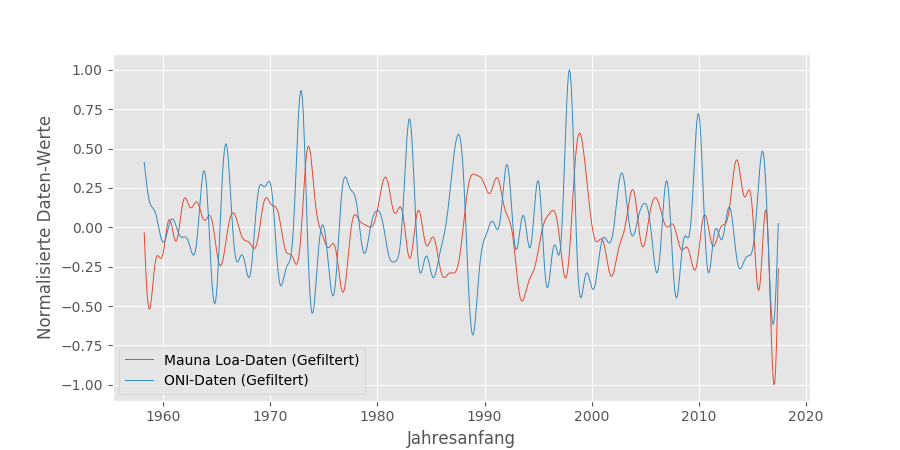

In [22]:
fig1 = plt.plot()
plt.plot(cut_a_filtered.mmlo_filtered / np.max(np.abs(cut_a_filtered.mmlo_filtered.values)), label='Mauna Loa-Daten (Gefiltert)')
plt.plot(cut_a_filtered.oeni_filtered / np.max(np.abs(cut_a_filtered.oeni_filtered.values)), label='ONI-Daten (Gefiltert)')
plt.ylabel('Normalisierte Daten-Werte')
plt.xlabel('Jahresanfang')
plt.legend()
plt.savefig('plots/filtered_mmlo_oeni.pdf')
plt.show()

## Filtered Auto-Correlations: Mauna Loa

<IPython.core.display.Javascript object>


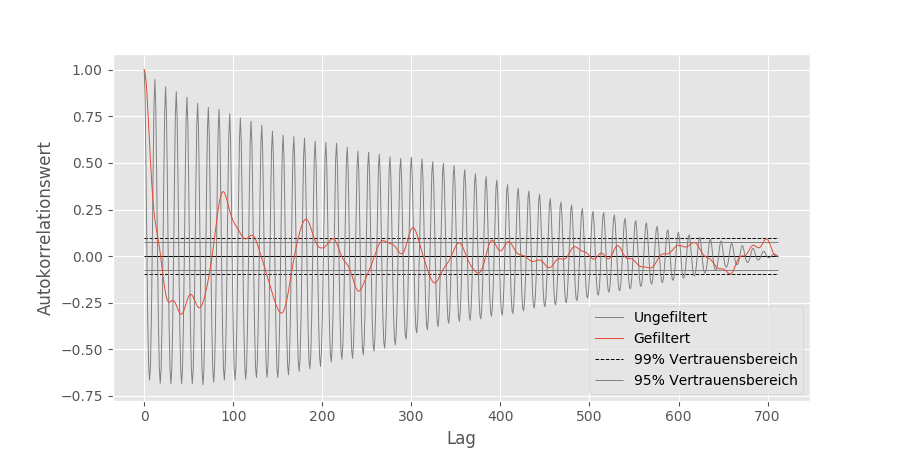

In [23]:
fig = plt.figure()
plt.plot(autocorr(mmlo.mmlo_notrend), '-', color='grey', label='Ungefiltert')
plt.plot(autocorr(filtered_mmlo.mmlo_filtered), color=myred, label='Gefiltert')
plot_ci(filtered_mmlo.mmlo_filtered)
plt.legend(loc='lower right')
plt.ylabel('Autokorrelationswert')
plt.xlabel('Lag')
plt.savefig('plots/autocorr_mmlo_filtered.pdf')

## Filtered Auto-Correlations: ONI

<IPython.core.display.Javascript object>


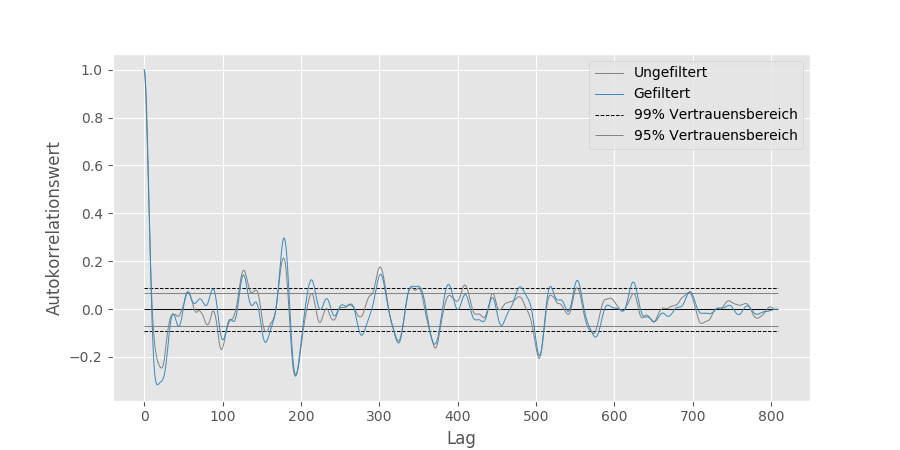

In [24]:
fig = plt.figure()
plt.plot(autocorr(oeni.oeni_data), '-', color='grey', label='Ungefiltert')
plt.plot(autocorr(filtered_oeni.oeni_filtered), color=myblue, label='Gefiltert')
plot_ci(filtered_oeni.oeni_filtered)
plt.legend()
plt.ylabel('Autokorrelationswert')
plt.xlabel('Lag')
plt.savefig('plots/autocorr_oeni_filtered.pdf')

## Unfiltered Auto-Correlation: Mauna Loa and ONI

<IPython.core.display.Javascript object>


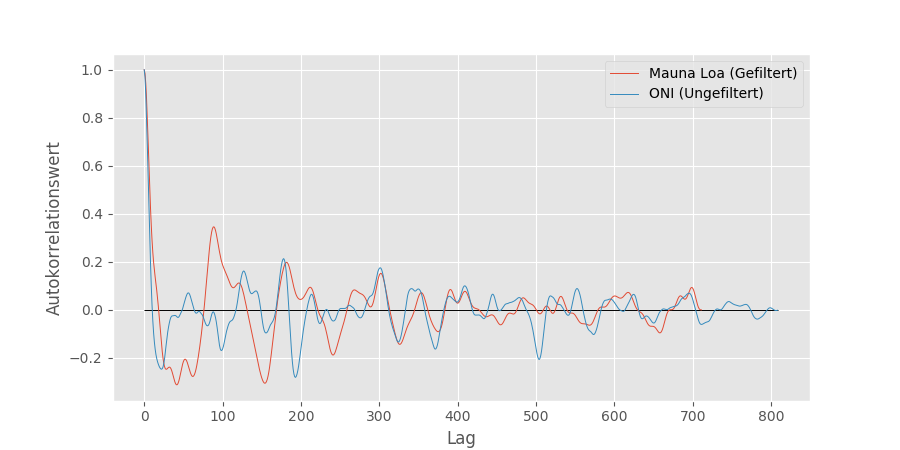

In [25]:
fig = plt.figure()
plt.plot(autocorr(filtered_mmlo.mmlo_filtered), color=myred, label='Mauna Loa (Gefiltert)')
plt.plot(autocorr(oeni.oeni_data), color=myblue, label='ONI (Ungefiltert)')
plt.hlines(0, 0, filtered_oeni.index.size)
plt.legend()
plt.ylabel('Autokorrelationswert')
plt.xlabel('Lag')
plt.savefig('plots/autocorr_mmlo_oeni_unfiltered.pdf')

## Filtered Auto-Correlation: Mauna Loa and ONI

<IPython.core.display.Javascript object>


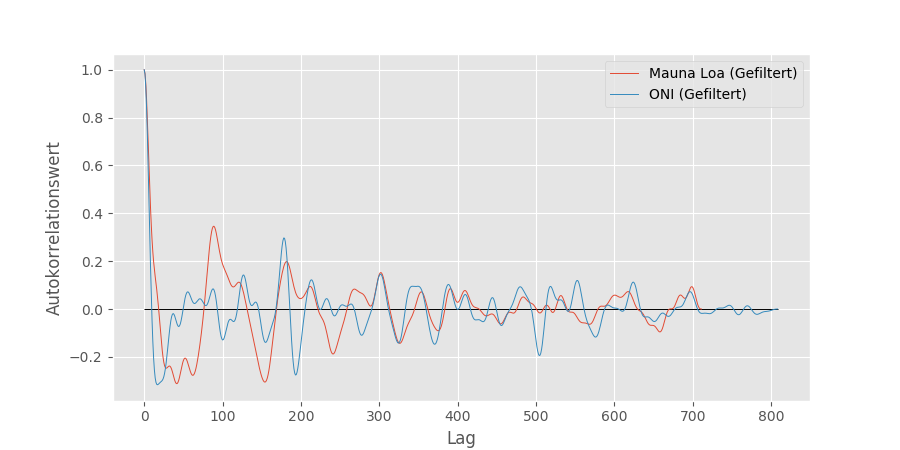

In [26]:
fig = plt.figure()
plt.plot(autocorr(filtered_mmlo.mmlo_filtered), color=myred, label='Mauna Loa (Gefiltert)')
plt.plot(autocorr(filtered_oeni.oeni_filtered), color=myblue, label='ONI (Gefiltert)')
# plt.plot(autocorr(oeni.oeni_data), '--', color='k', label='ONI (Ungefiltert)')

plt.hlines(0, 0, filtered_oeni.index.size)
plt.legend()
plt.ylabel('Autokorrelationswert')
plt.xlabel('Lag')
plt.savefig('plots/autocorr_mmlo_oeni_filtered.pdf')

## Filtered Cross-Correlation: ONI x Mauna Loa

<IPython.core.display.Javascript object>


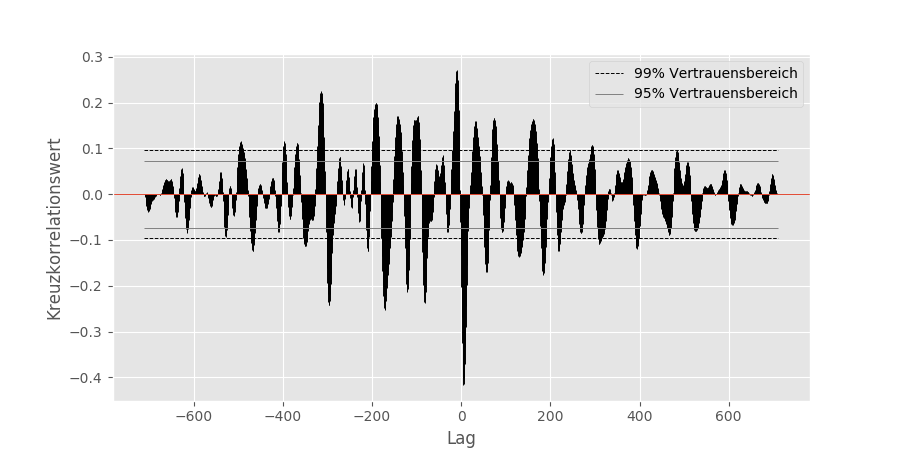

(array([-710, -709, -708, ...,  708,  709,  710]),
 array([ -2.37086257e-03,  -6.83067704e-03,  -1.26907748e-02, ...,
          6.40844343e-04,   2.51808673e-05,  -1.73805089e-05]),
 <matplotlib.lines.Line2D at 0x11a41c470>)

In [27]:
fig, ax = plt.subplots()
ax.xcorr(cut_a_filtered.oeni_filtered.values, cut_a_filtered.mmlo_filtered.values, maxlags=None)
ax.set_ylabel('Kreuzkorrelationswert')
ax.set_xlabel('Lag')
plot_ci(cut_a_filtered.oeni_filtered.values, oneside=False)
plt.legend()
plt.savefig('plots/crosscorr_oeni_mmlo_filtered.pdf')

##### ONI x Mauna Loa Cross-Correlation (Filtered, 100 Lags)

<IPython.core.display.Javascript object>


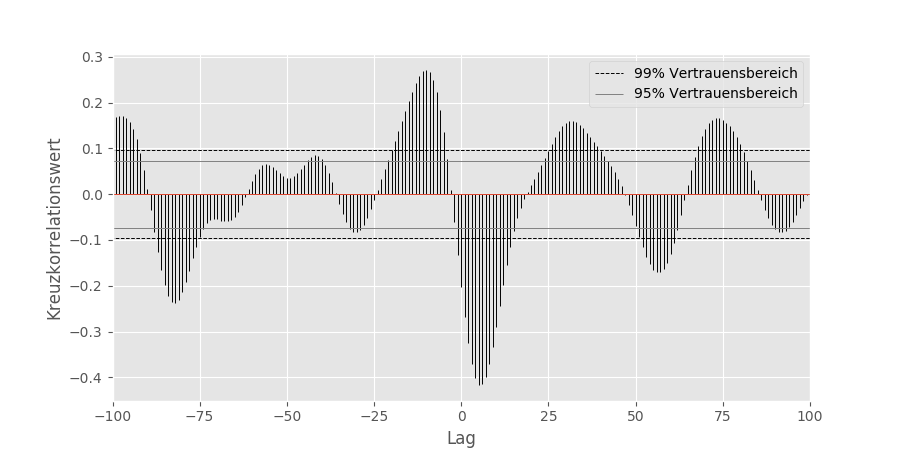

(array([-710, -709, -708, ...,  708,  709,  710]),
 array([ -2.37086257e-03,  -6.83067704e-03,  -1.26907748e-02, ...,
          6.40844343e-04,   2.51808673e-05,  -1.73805089e-05]),
 <matplotlib.lines.Line2D at 0x11a5520b8>)

(-100, 100)

In [28]:
fig, ax = plt.subplots()
ax.xcorr(cut_a_filtered.oeni_filtered.values, cut_a_filtered.mmlo_filtered.values, maxlags=None)
ax.set_ylabel('Kreuzkorrelationswert')
ax.set_xlabel('Lag')
plot_ci(cut_a_filtered.oeni_filtered.values, oneside=False)
plt.legend()
ax.set_xlim(-100, 100)
plt.savefig('plots/crosscorr_oeni_mmlo_filtered_100_lags.pdf')

##### ONI x Mauna Loa Cross-Correlation (Filtered vs Unfiltered, Lag 0 Detail)

<IPython.core.display.Javascript object>


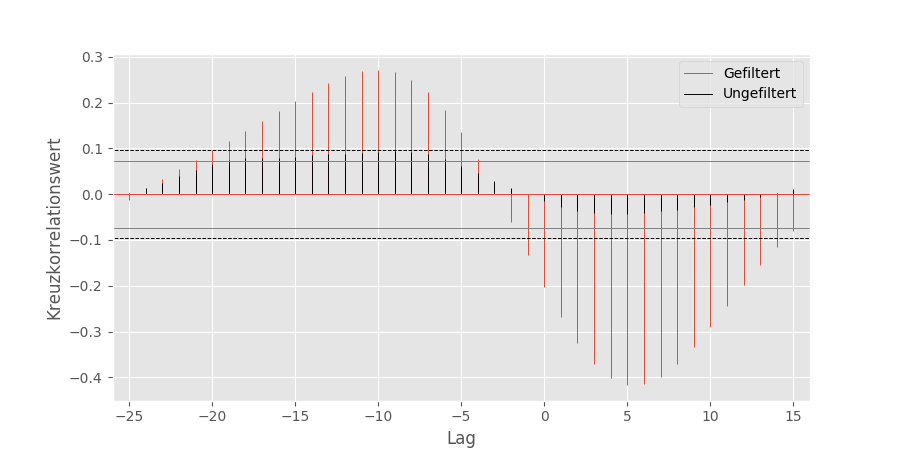

(array([-710, -709, -708, ...,  708,  709,  710]),
 array([ -2.37086257e-03,  -6.83067704e-03,  -1.26907748e-02, ...,
          6.40844343e-04,   2.51808673e-05,  -1.73805089e-05]),
 <matplotlib.lines.Line2D at 0x11a654940>)

(array([-710, -709, -708, ...,  708,  709,  710]),
 array([ 0.00433135,  0.00695822,  0.00759702, ...,  0.00225525,
         0.00156888,  0.00050131]),
 <matplotlib.lines.Line2D at 0x11a7da908>)

(-26, 16)

In [29]:
fig, ax = plt.subplots()
ax.xcorr(cut_a_filtered.oeni_filtered.values, cut_a_filtered.mmlo_filtered.values, maxlags=None, color=myred)
ax.plot(0, 0, color='k')
ax.xcorr(cut_a.oeni_data.values, cut_a.mmlo_notrend.values, maxlags=None)
ax.legend(['Gefiltert', 'Ungefiltert'])

plot_ci(cut_a_filtered.oeni_filtered.values, oneside=False)

ax.set_ylabel('Kreuzkorrelationswert')
ax.set_xlabel('Lag')
ax.set_xlim(-26, 16)
plt.savefig('plots/crosscorr_oeni_mmlo_filtered_detail.pdf')

## FFT Calculations with Filtered Data

### Standard Options for FFT Transform

In [30]:
padding_fac = 300  # padding factor
w_func = 'hamming'  # type of window function: ['hanning', 'hamming', 'black', 'nuttall', 'flattop']

### Filtered Mauna Loa FFT with Zero-Padding + Window-Function

In [31]:
fft_filtered_mmlo = mfft(filtered_mmlo.index, filtered_mmlo.mmlo_filtered, w=w_func, pad_fac=padding_fac)
fft_filtered_mmlo.tail()
%store fft_filtered_mmlo
%store fft_filtered_mmlo >data_results/fft_filtered_mmlo.txt

,freq,bin,bins_total,period_yr,mag,mag_norm,amp,amp_norm,pha,pha_norm
bin,,,,,,,,,,
106795,1.903876e-07,106795,106800,0.166674,0.010187,0.000145,9.538029e-08,0.000145,-3.008005,-0.957478
106796,1.903894e-07,106796,106800,0.166673,0.010180,0.000145,9.531385e-08,0.000145,-3.034692,-0.965973
106797,1.903911e-07,106797,106800,0.166671,0.010174,0.000145,9.526211e-08,0.000145,-3.061400,-0.974474
106798,1.903929e-07,106798,106800,0.166670,0.010170,0.000145,9.522511e-08,0.000145,-3.088122,-0.982980
106799,1.903947e-07,106799,106800,0.166668,0.010168,0.000145,9.520290e-08,0.000145,-3.114855,-0.991489


Stored 'fft_filtered_mmlo' (DataFrame)
Writing 'fft_filtered_mmlo' (DataFrame) to file 'data_results/fft_filtered_mmlo.txt'.


### Filtered Mauna Loa FFT with Zero-Padding + Window-Function (same Time-Range as ONI-Data):

In [32]:
fft_filtered_mmlo_cut_a = mfft(cut_a_filtered.index, cut_a_filtered.mmlo_filtered, w=w_func, pad_fac=padding_fac)
fft_filtered_mmlo_cut_a.tail()
%store fft_filtered_mmlo_cut_a
%store fft_filtered_mmlo_cut_a >data_results/fft_filtered_mmlo_cut_a.txt

,freq,bin,bins_total,period_yr,mag,mag_norm,amp,amp_norm,pha,pha_norm
bin,,,,,,,,,,
106645,1.903841e-07,106645,106650,0.166674,0.006719,0.000096,6.300169e-08,0.000096,-2.992815,-0.952643
106646,1.903859e-07,106646,106650,0.166673,0.006711,0.000096,6.292751e-08,0.000096,-3.022510,-0.962095
106647,1.903877e-07,106647,106650,0.166671,0.006705,0.000096,6.286972e-08,0.000096,-3.052245,-0.971560
106648,1.903894e-07,106648,106650,0.166670,0.006701,0.000096,6.282839e-08,0.000096,-3.082011,-0.981034
106649,1.903912e-07,106649,106650,0.166668,0.006698,0.000096,6.280357e-08,0.000096,-3.111797,-0.990516


Stored 'fft_filtered_mmlo_cut_a' (DataFrame)
Writing 'fft_filtered_mmlo_cut_a' (DataFrame) to file 'data_results/fft_filtered_mmlo_cut_a.txt'.


### Filtered ONI FFT with Zero-Padding + Window-Function:

In [33]:
fft_filtered_oeni = mfft(filtered_oeni.index, filtered_oeni.oeni_filtered, w=w_func, pad_fac=padding_fac)
fft_filtered_oeni.tail()
%store fft_filtered_oeni
%store fft_filtered_oeni >data_results/fft_filtered_oeni.txt

,freq,bin,bins_total,period_yr,mag,mag_norm,amp,amp_norm,pha,pha_norm
bin,,,,,,,,,,
121345,1.903676e-07,121345,121350,0.166674,0.012663,0.000123,1.043545e-07,0.000123,0.088459,0.028158
121346,1.903692e-07,121346,121350,0.166672,0.012667,0.000123,1.043814e-07,0.000123,0.070762,0.022525
121347,1.903707e-07,121347,121350,0.166671,0.012669,0.000123,1.044023e-07,0.000123,0.053069,0.016893
121348,1.903723e-07,121348,121350,0.166669,0.012671,0.000123,1.044172e-07,0.000123,0.035378,0.011261
121349,1.903739e-07,121349,121350,0.166668,0.012672,0.000123,1.044262e-07,0.000123,0.017689,0.005631


Stored 'fft_filtered_oeni' (DataFrame)
Writing 'fft_filtered_oeni' (DataFrame) to file 'data_results/fft_filtered_oeni.txt'.


### Filtered ONI FFT with Zero-Padding + Window-Function (same Time-Range as Mauna Loa-Data)

In [34]:
fft_filtered_oeni_cut_a = mfft(cut_a_filtered.index, cut_a_filtered.oeni_filtered, w=w_func, pad_fac=padding_fac)
fft_filtered_oeni_cut_a.tail()
%store fft_filtered_oeni_cut_a
%store fft_filtered_oeni_cut_a >data_results/fft_filtered_oeni_cut_a.txt

,freq,bin,bins_total,period_yr,mag,mag_norm,amp,amp_norm,pha,pha_norm
bin,,,,,,,,,,
106645,1.903841e-07,106645,106650,0.166674,0.053352,0.000578,5.002514e-07,0.000578,0.020915,0.006658
106646,1.903859e-07,106646,106650,0.166673,0.053369,0.000578,5.004097e-07,0.000578,0.016738,0.005328
106647,1.903877e-07,106647,106650,0.166671,0.053382,0.000578,5.005328e-07,0.000578,0.012556,0.003997
106648,1.903894e-07,106648,106650,0.166670,0.053391,0.000578,5.006207e-07,0.000578,0.008372,0.002665
106649,1.903912e-07,106649,106650,0.166668,0.053397,0.000578,5.006735e-07,0.000578,0.004187,0.001333


Stored 'fft_filtered_oeni_cut_a' (DataFrame)
Writing 'fft_filtered_oeni_cut_a' (DataFrame) to file 'data_results/fft_filtered_oeni_cut_a.txt'.


## Comparing Window Functions on Filtered Mauna Loa Data:

In [35]:
fft_filtered_mmlo_nuttall = mfft(filtered_mmlo.index, filtered_mmlo.mmlo_filtered, w='nuttall', pad_fac=padding_fac)
fft_filtered_mmlo_flattop = mfft(filtered_mmlo.index, filtered_mmlo.mmlo_filtered, w='flattop', pad_fac=padding_fac)
fft_filtered_mmlo_hann = mfft(filtered_mmlo.index, filtered_mmlo.mmlo_filtered, w='hanning', pad_fac=padding_fac)
fft_filtered_mmlo_hamm = mfft(filtered_mmlo.index, filtered_mmlo.mmlo_filtered, w='hamming', pad_fac=padding_fac)
fft_filtered_mmlo_black = mfft(filtered_mmlo.index, filtered_mmlo.mmlo_filtered, w='black', pad_fac=padding_fac)

<IPython.core.display.Javascript object>


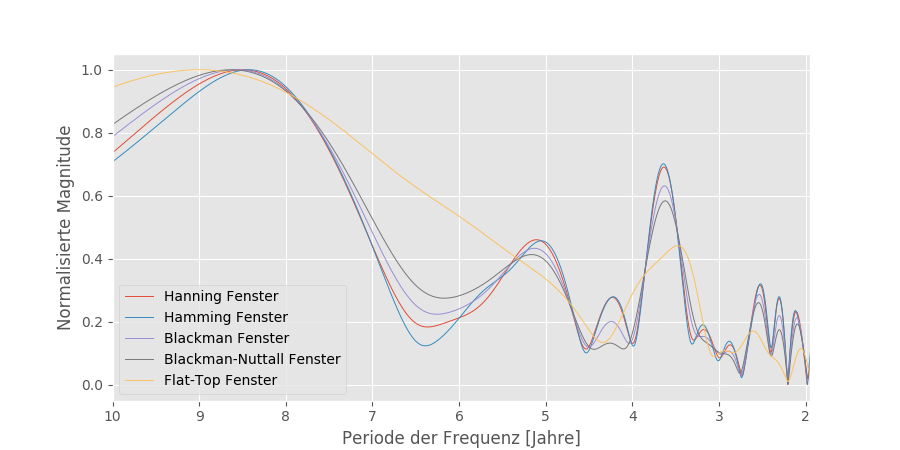

(10, 1.95)

In [36]:
x_start = 10
x_stop = 1.95

fig = plt.figure()
plt.plot(fft_filtered_mmlo_hann.period_yr.values, fft_filtered_mmlo_hann.mag_norm.values, label='Hanning Fenster')
plt.plot(fft_filtered_mmlo_hamm.period_yr.values, fft_filtered_mmlo_hamm.mag_norm.values, label='Hamming Fenster')
plt.plot(fft_filtered_mmlo_black.period_yr.values, fft_filtered_mmlo_black.mag_norm.values, label='Blackman Fenster')
plt.plot(fft_filtered_mmlo_nuttall.period_yr.values, fft_filtered_mmlo_nuttall.mag_norm.values, label='Blackman-Nuttall Fenster')
plt.plot(fft_filtered_mmlo_flattop.period_yr.values, fft_filtered_mmlo_flattop.mag_norm.values, label='Flat-Top Fenster')

plt.ylabel('Normalisierte Magnitude')
plt.xlabel('Periode der Frequenz [Jahre]')
plt.xlim(x_start, x_stop)
# plt.xscale('log')
plt.legend()
plt.savefig('plots/fft_mmlo_filtered_win_compare.pdf')